In [1]:
# Importing libraries
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Modeling 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

#Scoring
#Defining and calling scoring functions
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,precision_recall_curve
from sklearn.metrics import confusion_matrix,balanced_accuracy_score,accuracy_score,f1_score
from sklearn.metrics import make_scorer

def perf_measure(y_actual, y_hat):
    TN, FP, FN, TP = confusion_matrix(y_actual, y_hat).ravel()
    return(TP, FP, TN, FN)

def TSS_score(y_actual,y_pred):
    
    TP,FP,TN,FN=perf_measure(y_actual,y_pred)
    rec=TP/(TP+FN)
    TSSscore=rec-(FP/(TN+FP))
    return TSSscore

def HSS_score(y_actual,y_pred):
    TP,FP,TN,FN=perf_measure(y_actual,y_pred)
    HSSscore=(2*(TP*TN-FP*FN))/((TP+FN)*(FN+TN)+(TP+FP)*(FP+TN))
    return HSSscore

TSS = make_scorer(TSS_score, greater_is_better=True)

In [2]:
%%time
# Imporing the data
df = pd.read_csv('Labeled_Dataset.csv', low_memory=False)
X = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
     'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANSHR', 'MEANGAM']
Y = ['LABEL']
x = df[X]
y = df[Y]

Wall time: 22.2 s


Before we run the SVM algorithm to investigate the prediction performance, we need to find the most optimal parameter used in the SVM, the process which called hyperparameter tuning. Here we use LinearSVC which utilize linear kernel for the SVC. We choose this because SVC using any other kernel uses too much computational resource. 

In LinearSVC, there is only one parameter which needs to be optimized: C. It is the l2 regularization parameter. The value of C is inversely proportional to the strength of the regularization. When C is small, the penalty for misclassification is small, and the strength of the regularization is large. So a decision boundary with a large margin will be selected. When C is large, the penalty for misclassification is large, and the strength of the regularization is small. A decision boundary with a small margin will be selected to reduce misclassifications.

Below we will perform two hyperparameter tuning methods: Grid Search & Bayesian Optimization

## Hyperparameter Tuning Using Grid Search

In [13]:
%%time
# List of C values
C_range = np.logspace(-2, -1, 7)
print(f'The list of values for C are {C_range}')

# Define the search space
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    }
# Set up score
scoring = {'accuracy':'accuracy', 'balanced_accuracy':'balanced_accuracy', 'precision':'precision', 'recall':'recall', 'f1':'f1', 'TSS':TSS}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=203)

The list of values for C are [0.01       0.01467799 0.02154435 0.03162278 0.04641589 0.06812921
 0.1       ]
Wall time: 1 ms


In [14]:
%%time
svc = LinearSVC(random_state=203, class_weight='balanced')
# Define grid search
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='TSS', 
                           n_jobs=6, 
                           cv=kfold, 
                           verbose=10)
# Fit grid search
grid_result = grid_search.fit(x, y.values.ravel())
# Print grid search summary
grid_result

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Wall time: 59min 54s


C:\Users\joko\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=203, shuffle=True),
             estimator=LinearSVC(class_weight='balanced', random_state=203),
             n_jobs=6,
             param_grid={'C': array([0.01      , 0.01467799, 0.02154435, 0.03162278, 0.04641589,
       0.06812921, 0.1       ])},
             refit='TSS',
             scoring={'TSS': make_scorer(TSS_score), 'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=10)

In [15]:
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')

The best hyperparameters are {'C': 0.06812920690579612}


In [22]:
X = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
    'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANSHR', 'MEANGAM']
len(X)

12

## Support Vector Machine Performance vs Number of  Fetures

In [4]:
%%time
skf = StratifiedKFold(n_splits=5)
target = df.loc[:,'LABEL']

model = LinearSVC(random_state=203, class_weight='balanced', C=0.06812920690579612, verbose=1)

def train_model(train, test, fold_no, it):
    X = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
       'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANSHR', 'MEANGAM']
    y = ['LABEL']
    X_train = train[X[:it]]
    y_train = train[y]
    X_test = test[X[:it]]
    y_test = test[y]
    model.fit(X_train,y_train.values.ravel())
    predictions = model.predict(X_test)
    print(' Fold', str(fold_no))
    print('Number of Train:', str(len(X_train)))
    print('Number of Test:', str(len(X_test)))
    print('Accuracy:', accuracy_score(y_test, predictions))
    print('Precision:', precision_score(y_test, predictions))
    print('Recall:', recall_score(y_test, predictions))
    print('f1:', f1_score(y_test, predictions))
    print('TSS:', TSS_score(y_test, predictions))
    print()
    return accuracy_score(y_test, predictions), precision_score(y_test, predictions), recall_score(y_test, predictions), f1_score(y_test, predictions), TSS_score(y_test, predictions)

Wall time: 0 ns


In [10]:
%%time

ACCURACY = []
PRECISION = []
RECALL = []
F1 = []
TSS_ = []

for it in range(12, 0, -1):

    fold_no = 1
    accuracy_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    TSS_per_fold = []

    for train_index, test_index in skf.split(df, target):
        train = df.loc[train_index,:]
        test = df.loc[test_index,:]
        acc, prec, recall, f1, tss = train_model(train,test,fold_no, it)
        accuracy_per_fold.append(acc)
        precision_per_fold.append(prec)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)
        TSS_per_fold.append(tss)
        fold_no += 1
    
    ACCURACY.append(np.average(accuracy_per_fold))
    PRECISION.append(np.average(precision_per_fold))
    RECALL.append(np.average(recall_per_fold))
    F1.append(np.average(f1_per_fold))
    TSS_.append(np.average(TSS_per_fold))

[LibLinear] Fold 1
Number of Train: 1063052
Number of Test: 265764
Accuracy: 0.8405276862178475
Precision: 0.18781946280910186
Recall: 0.8857142857142857
f1: 0.3099192392861795
TSS: 0.724338074530021

[LibLinear] Fold 2
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.8512622148305069
Precision: 0.19979140592407177
Recall: 0.8913913448115403
f1: 0.3264207207974781
TSS: 0.7409627476144797

[LibLinear] Fold 3
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.8396917554362345
Precision: 0.1940459041582637
Recall: 0.9402512796649605
f1: 0.3217003661837287
TSS: 0.7757060318785297

[LibLinear] Fold 4
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.8882049043696828
Precision: 0.24684997330485853
Recall: 0.860586319218241
f1: 0.3836531480136915
TSS: 0.7499549128077131

[LibLinear] Fold 5
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.890074991627879
Precision: 0.26162265417279745
Recall: 0.9432294090274547
f1: 0.40962735429633823
TSS: 0.83106477751

f1: 0.41224741485627553
TSS: 0.7197185503004091

[LibLinear] Fold 2
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.904809924632097
Precision: 0.27224639268834705
Recall: 0.8094927873429502
f1: 0.40745772239658967
TSS: 0.7183188309947708

[LibLinear] Fold 3
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.8813943250189078
Precision: 0.23405017921146953
Recall: 0.850814332247557
f1: 0.367111735769501
TSS: 0.7334971232662302

[LibLinear] Fold 4
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.9321274970556473
Precision: 0.3546690048224463
Recall: 0.8281991624011168
f1: 0.4966514119879451
TSS: 0.7647056050835941

[LibLinear] Fold 5
Number of Train: 1063053
Number of Test: 265763
Accuracy: 0.9452369216181334
Precision: 0.4074092080315037
Recall: 0.7798976268031642
f1: 0.5352238615315833
TSS: 0.732101000682655

[LibLinear] Fold 1
Number of Train: 1063052
Number of Test: 265764
Accuracy: 0.9035309522734456
Precision: 0.2677396213468076
Recall: 0.798883201489

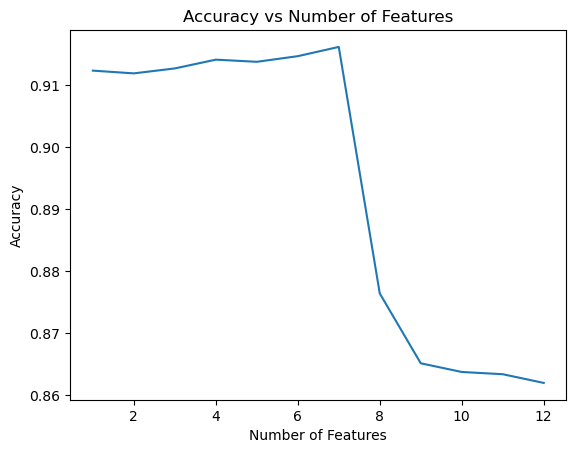

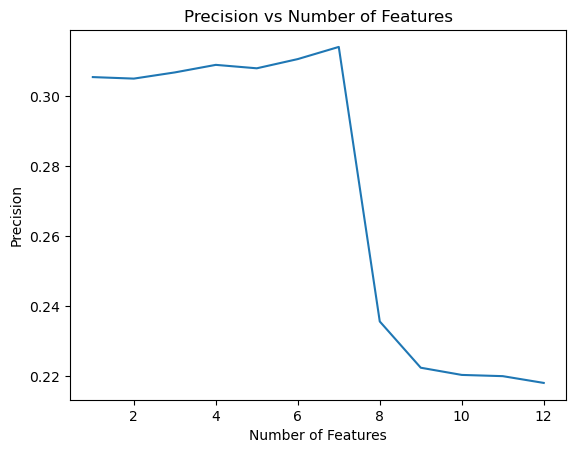

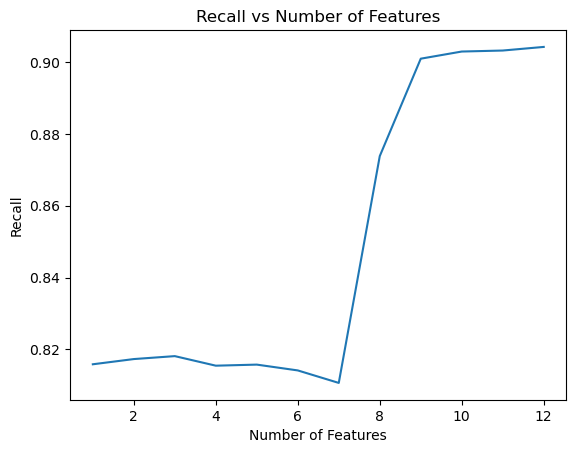

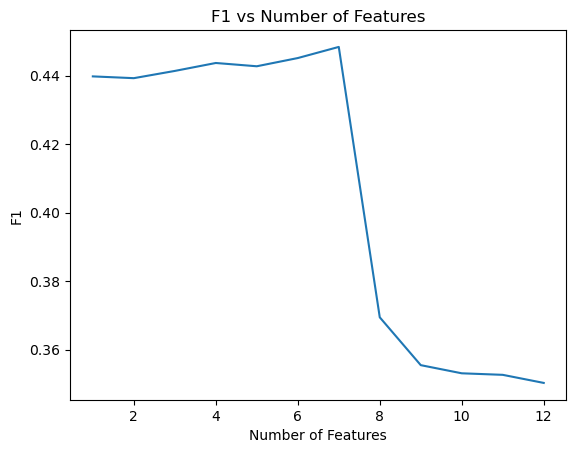

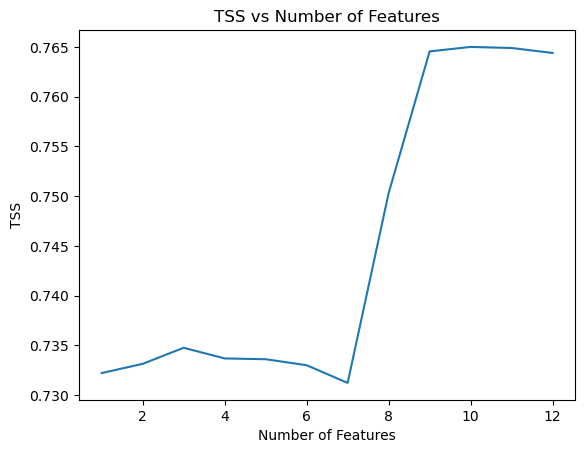

In [12]:
# Plotting performance vs n-features
x_axis = np.arange(12, 0, -1)

plt.plot(x_axis, ACCURACY)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.show()

plt.plot(x_axis, PRECISION)
plt.xlabel('Number of Features')
plt.ylabel('Precision')
plt.title('Precision vs Number of Features')
plt.show()

plt.plot(x_axis, RECALL)
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.title('Recall vs Number of Features')
plt.show()

plt.plot(x_axis, F1)
plt.xlabel('Number of Features')
plt.ylabel('F1')
plt.title('F1 vs Number of Features')
plt.show()

plt.plot(x_axis, TSS_)
plt.xlabel('Number of Features')
plt.ylabel('TSS')
plt.title('TSS vs Number of Features')
plt.show()